In [1]:
!pip -q install torch torchvision pillow

In [11]:
import os
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

In [12]:
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
set_seed(0)

SAVE_DIR = "out_ddpm_mnist"
os.makedirs(SAVE_DIR, exist_ok=True)


Using device: cuda


In [13]:
@torch.no_grad()
def to01(x: torch.Tensor) -> torch.Tensor:
    return (x.clamp(-1, 1) + 1) / 2

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        device = t.device
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.linspace(math.log(1e-4), math.log(1.0),
                           steps=half_dim, device=device)
        )
        args = t.float().unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

class TimeMLP(nn.Module):
    def __init__(self, time_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.net(t)

class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, time_dim: int, groups: int = 8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act = nn.SiLU()
        self.time_proj = nn.Linear(time_dim, out_ch)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        time_term = self.time_proj(t_emb)[:, :, None, None]

        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h + time_term)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)
        return h

class SimpleUNet(nn.Module):
    def __init__(self, img_ch: int = 1, base_ch: int = 32, time_dim: int = 128):
        super().__init__()
        self.time_mlp = TimeMLP(time_dim)

        self.down1 = DoubleConv(img_ch, base_ch, time_dim)
        self.down2 = DoubleConv(base_ch, base_ch * 2, time_dim)
        self.mid   = DoubleConv(base_ch * 2, base_ch * 4, time_dim)

        self.pool = nn.MaxPool2d(2)
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(base_ch * 4, base_ch * 2, time_dim)

        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(base_ch * 2, base_ch, time_dim)

        self.out_conv = nn.Conv2d(base_ch, img_ch, kernel_size=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t_emb = self.time_mlp(t)

        # encoder
        x1 = self.down1(x, t_emb)                     # (B, 32, 28, 28)
        x2 = self.down2(self.pool(x1), t_emb)         # (B, 64, 14, 14)
        xm = self.mid(self.pool(x2), t_emb)           # (B,128,  7, 7)

        # decoder
        x = self.up2(xm)                              # (B, 64, 14, 14)
        x = torch.cat([x, x2], dim=1)                 # (B,128, 14, 14)
        x = self.conv_up2(x, t_emb)                   # (B, 64, 14, 14)

        x = self.up1(x)                               # (B, 32, 28, 28)
        x = torch.cat([x, x1], dim=1)                 # (B, 64, 28, 28)
        x = self.conv_up1(x, t_emb)                   # (B, 32, 28, 28)

        x = self.out_conv(x)                          # (B, 1, 28, 28)
        return x


@dataclass
class DiffusionConfig:
    T: int = 250
    beta_start: float = 1e-4
    beta_end: float = 2e-2

class Diffusion(nn.Module):
    def __init__(self, cfg: DiffusionConfig):
        super().__init__()
        self.cfg = cfg

        T = cfg.T
        betas = torch.linspace(cfg.beta_start, cfg.beta_end, T, dtype=torch.float32)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], dtype=torch.float32), alphas_cumprod[:-1]], dim=0
        )

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)

        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod",
            torch.sqrt(1.0 - alphas_cumprod)
        )
        self.register_buffer(
            "sqrt_recip_alphas",
            torch.sqrt(1.0 / alphas)
        )
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.register_buffer("posterior_variance", posterior_variance)

    def _extract(self, a: torch.Tensor, t: torch.Tensor, x_shape):
        out = a[t]  # (B,)
        return out.view(-1, *([1] * (len(x_shape) - 1)))

    @torch.no_grad()
    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor = None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_bar_alpha_t = self._extract(self.sqrt_alphas_cumprod, t, x0.shape)
        sqrt_one_minus_bar_alpha_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x0.shape
        )
        return sqrt_bar_alpha_t * x0 + sqrt_one_minus_bar_alpha_t * noise

    def training_loss(self, model: nn.Module, x0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, noise)
        eps_pred = model(xt, t)
        return F.mse_loss(eps_pred, noise)

    @torch.no_grad()
    def p_sample(self, model: nn.Module, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        betas_t = self._extract(self.betas, t, xt.shape)
        sqrt_one_minus_bar_alpha_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, xt.shape
        )
        sqrt_recip_alpha_t = self._extract(self.sqrt_recip_alphas, t, xt.shape)
        posterior_var_t = self._extract(self.posterior_variance, t, xt.shape)

        eps_theta = model(xt, t)
        model_mean = sqrt_recip_alpha_t * (xt - betas_t * eps_theta / sqrt_one_minus_bar_alpha_t)

        noise = torch.randn_like(xt)
        nonzero_mask = (t > 0).float().view(-1, 1, 1, 1)  # t=0 no noise
        return model_mean + nonzero_mask * torch.sqrt(posterior_var_t) * noise

    @torch.no_grad()
    def sample(self, model: nn.Module, shape, device=None):
        if device is None:
            device = next(model.parameters()).device
        B = shape[0]
        xt = torch.randn(shape, device=device)
        for i in reversed(range(self.cfg.T)):
            t = torch.full((B,), i, device=device, dtype=torch.long)
            xt = self.p_sample(model, xt, t)
        return xt


@torch.no_grad()
def sample_with_snaps(diffusion: Diffusion, model: nn.Module, shape, device):
    B = shape[0]
    xt = torch.randn(shape, device=device)
    snaps = [xt.detach().cpu()]
    for i in reversed(range(diffusion.cfg.T)):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        xt = diffusion.p_sample(model, xt, t)
        snaps.append(xt.detach().cpu())
    return xt, snaps

def get_loader(batch_size: int = 128, limit_train: int = None):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 2.0 - 1.0),  # [0,1] -> [-1,1]
    ])
    root = os.path.expanduser("~/.torch_datasets")
    ds = datasets.MNIST(root=root, train=True, transform=tfm, download=True)
    if limit_train is not None:
        limit_train = min(limit_train, len(ds))
        ds = torch.utils.data.Subset(ds, list(range(limit_train)))
    return DataLoader(
        ds, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )



Epoch 1/200 - loss = 0.0927
Epoch 2/200 - loss = 0.0555
Epoch 3/200 - loss = 0.0507
Epoch 4/200 - loss = 0.0480
Epoch 5/200 - loss = 0.0464
Epoch 6/200 - loss = 0.0456
Epoch 7/200 - loss = 0.0451
Epoch 8/200 - loss = 0.0449
Epoch 9/200 - loss = 0.0436
Epoch 10/200 - loss = 0.0435
Epoch 11/200 - loss = 0.0434
Epoch 12/200 - loss = 0.0428
Epoch 13/200 - loss = 0.0429
Epoch 14/200 - loss = 0.0429
Epoch 15/200 - loss = 0.0422
Epoch 16/200 - loss = 0.0423
Epoch 17/200 - loss = 0.0419
Epoch 18/200 - loss = 0.0419
Epoch 19/200 - loss = 0.0415
Epoch 20/200 - loss = 0.0417
Epoch 21/200 - loss = 0.0415
Epoch 22/200 - loss = 0.0413
Epoch 23/200 - loss = 0.0411
Epoch 24/200 - loss = 0.0412
Epoch 25/200 - loss = 0.0409
Epoch 26/200 - loss = 0.0412
Epoch 27/200 - loss = 0.0409
Epoch 28/200 - loss = 0.0409
Epoch 29/200 - loss = 0.0407
Epoch 30/200 - loss = 0.0406
Epoch 31/200 - loss = 0.0407
Epoch 32/200 - loss = 0.0408
Epoch 33/200 - loss = 0.0405
Epoch 34/200 - loss = 0.0406
Epoch 35/200 - loss = 0

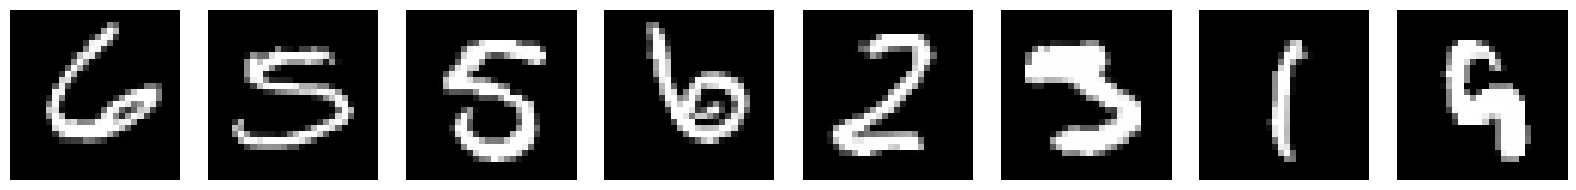

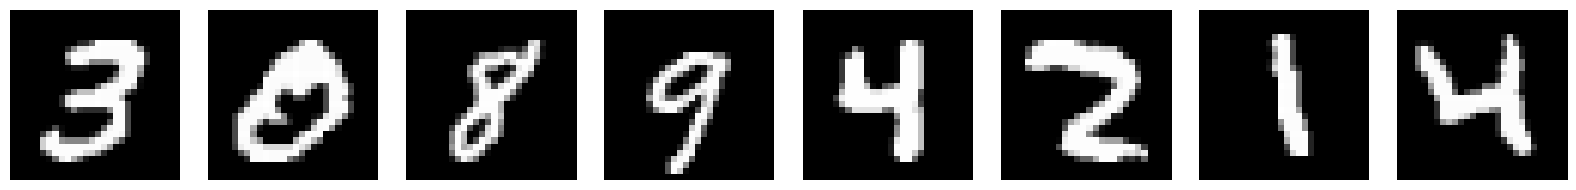

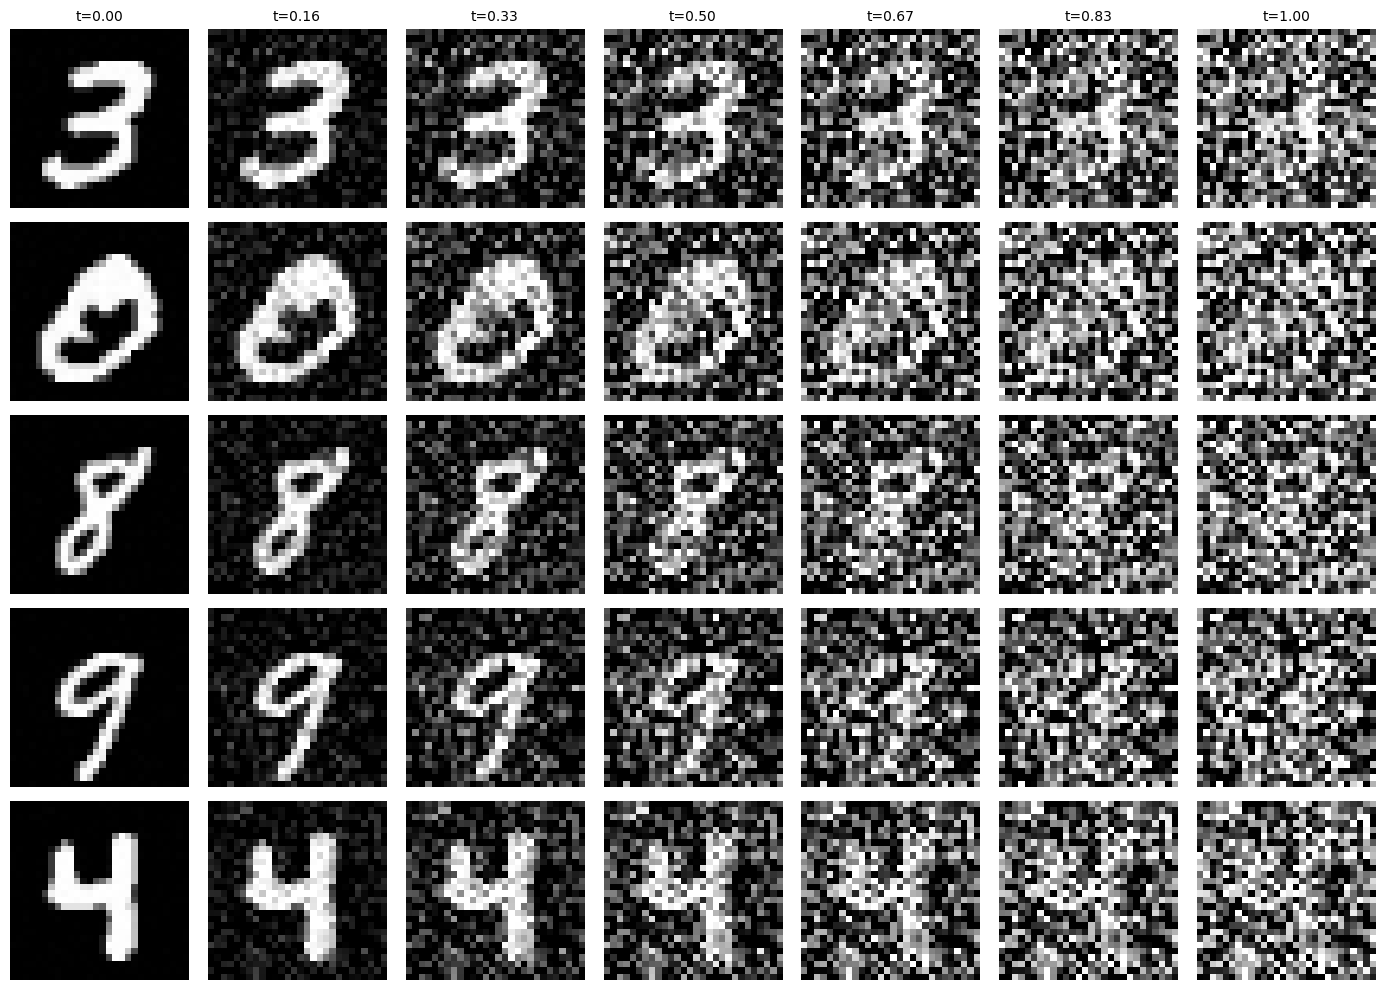

In [14]:

cfg = DiffusionConfig(T=250, beta_start=1e-4, beta_end=2e-2)
diff = Diffusion(cfg).to(device)
model = SimpleUNet(img_ch=1, base_ch=64, time_dim=128).to(device)

BATCH_SIZE = 128
NUM_EPOCHS = 200
LR = 5e-4

dl = get_loader(BATCH_SIZE, limit_train=None)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x0, _ in dl:
        x0 = x0.to(device, non_blocking=True)
        t = torch.randint(0, cfg.T, (x0.size(0),), device=device).long()

        loss = diff.training_loss(model, x0, t)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running_loss += loss.item() * x0.size(0)

    avg_loss = running_loss / len(dl.dataset)
    print(f"Epoch {epoch}/{NUM_EPOCHS} - loss = {avg_loss:.4f}")


model.eval()
with torch.no_grad():
    gen_row = diff.sample(model, shape=(8, 1, 28, 28), device=device)
    gen_row_01 = to01(gen_row.cpu())

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    img = gen_row_01[i, 0].numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "generated_digits_row.png"),
            dpi=200, bbox_inches="tight")
plt.show()


dl_vis = get_loader(batch_size=64, limit_train=64)
x_real, y_real = next(iter(dl_vis))
x_real = x_real[:8]

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    img = to01(x_real[i]).squeeze().numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "real_digits_row.png"),
            dpi=200, bbox_inches="tight")
plt.show()


num_rows = 5
x_rows = x_real[:num_rows].to(device)

fractions = [0.00, 0.16, 0.33, 0.50, 0.67, 0.83, 1.00]
timesteps = [int(f * (cfg.T - 1)) for f in fractions]

fig, axes = plt.subplots(num_rows, len(timesteps),
                         figsize=(len(timesteps) * 2.0, num_rows * 2.0))

for i in range(num_rows):
    x0 = x_rows[i:i+1]
    noise = torch.randn_like(x0)

    for j, t_int in enumerate(timesteps):
        t_batch = torch.full((1,), t_int, device=device, dtype=torch.long)
        xt = diff.q_sample(x0, t_batch, noise=noise)

        img = to01(xt.detach().cpu()).squeeze().numpy()
        ax = axes[i, j]
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        if i == 0:
            ax.set_title(f"t={fractions[j]:.2f}", fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "forward_diffusion_grid.png"),
            dpi=300, bbox_inches="tight")
plt.show()
